In [60]:
import random
import numpy as np

#num_complex = 4
#delta = 0.01
#alpha = 0.02

In [188]:
from pprint import pprint

def main():
    N = 8
    K = 4
    grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

    dataset = {}

    # horizontal

    for i in range(N):
        for j in range(N):
            grid[i][j] = [0,1,0,0]
        if 1 not in dataset:
            dataset[1] = [grid]
        else:
            dataset[1].append(grid)
        
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

    # vertical

    for i in range(N):
        for j in range(N):
            grid[j][i] = [1,0,0,0]
            if 2 not in dataset:
                dataset[2] = [grid]
        else:
            dataset[2].append(grid)
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

    # ldiagonal - da
    
    row = 0
    col = 0

    for i in range(N):
        col = i
        row = 0

        while (col >= 0 and row < N):
            grid[row][col] = [0,0,1,0]
            row += 1
            col -= 1
        if 3 not in dataset:
            dataset[3] = [grid]
        else:
            dataset[3].append(grid)
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

    
    for i in range(1, N):
        row = i
        col = N - 1

        while (col >= 0 and row < N):
            grid[row][col] = [0,0,1,0]
            row += 1
            col -= 1
        if 3 not in dataset:
            dataset[3] = [grid]
        else:
            dataset[3].append(grid)
        
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

    # rdiagonal - db

    for i in range(N):
        col = N - 1 - i
        row = 0

        while (col < N and row < N):
            grid[row][col] = [0,0,0,1]
            row += 1
            col += 1
        if 4 not in dataset:
            dataset[4] = [grid]
        else:
            dataset[4].append(grid)
        
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])

        

    for i in range(1, N):
        row = i
        col = 0

        while (col >= 0 and row < N):
            grid[row][col] = [0,0,0,1]
            row += 1
            col += 1
        if 4 not in dataset:
            dataset[4] = [grid]
        else:
            dataset[4].append(grid)
        
        grid = np.array([[[0,0,0,0] for _ in range(N)] for _ in range(N)])
    
    dataset[5] = (dataset[2][:5] + dataset[3][4:])[1:]
    dataset[6] = dataset[2][:5] + dataset[4][::-1][4:]

    return dataset

        
            
if __name__ == '__main__':
    main()

In [190]:
data = main()
#v, h, da, db, h2da, h2db
data = [data[1], data[2], data[3], data[4], data[5], data[6]]


In [212]:
import copy

#initialize grid of simple cells
def make_grid(n):
    return [[make_simple_unit() for i in range(n)] for j in range(n)]

#initialize simple unit with four feature detectors
def make_simple_unit():
    return {'v': initialize(),'h':initialize(),'da':initialize(),'db':initialize()}

#initialize feature detector, one weight for each connection to each complex cell
def initialize():
    return {'firing':0, 'weights':[random.uniform(0,0.1) for i in range(num_complex)]}

#initialize complex unit
def make_complex_unit():
    return {'firing':0,'trace':0}

#initialize complex layer
def make_complex_layer(num_complex):
    return [make_complex_unit() for i in range(num_complex)]

#determine feature detector connection weight change for each time step
def find_weight_change(trace,firing,weight,alpha):
    return alpha*trace*(firing - weight)

#determine new complex cell trace for each time step
def find_new_trace(firing, trace, delta):
    return (1-delta)*trace + delta*firing    

#determines which complex cell should fire
def which_firing(grid, complex_layer,alpha):
    sums = {i:0 for i in range(num_complex)}
    for i,row in enumerate(grid):
        for j,unit in enumerate(row):
            for orientation in unit:
                firing = unit[orientation]['firing']
                if (firing == 1):
                    for complex_cell_num in sums:
                        sums[complex_cell_num] += firing * unit[orientation]['weights'][complex_cell_num]
                weights = unit[orientation]['weights']
                for complex_cell_num, weight in enumerate(weights):
                    grid[i][j][orientation]['weights'][complex_cell_num] += find_weight_change(complex_layer[complex_cell_num]['trace'],firing,weight,alpha)
    inverse = [(value, key) for key, value in sums.iteritems()]
    return max(inverse)[1]

#find instances of firing feature detectors in a frame (firing feature detectors -> "ffds")
def read_frame(frame):
    ffds = []
    for (row_num,col_num,feature_detector),is_firing in np.ndenumerate(frame):
        if (is_firing == 1):
            ffds.append((row_num,col_num,feature_detector))
    return ffds

def run_model(data, nsims, num_complex, delta, alpha):
    grid = make_grid(len(data[1][0]))
    complex_layer = make_complex_layer(num_complex)
    fd2orient = {0:'v', 1:'h', 2:'da', 3:'db'}
    complex_num_firing = 0
    grid_record = []
    complex_record = []
    for frames in data:
        #train frame a given number of times
        for i in range(nsims):
            #read through frames
            for frame in frames:
                
                #determine which feature detectors are firing
                ffds = read_frame(frame)
                for index in ffds:
                    row = index[0]
                    col = index[1]
                    orientation = fd2orient[index[2]]
                    grid[row][col][orientation]['firing'] = 1
                
                #determine which complex cell will fire
                complex_num_firing = which_firing(grid, complex_layer,alpha)
                complex_layer[complex_num_firing]['firing'] = 1
                
                #determine new trace of each complex unit
                for complex_unit in complex_layer:
                    complex_unit['trace'] = find_new_trace(complex_unit['firing'],complex_unit['trace'],delta)  
                
                #reset units
                for index in ffds:
                    row = index[0]
                    col = index[1]
                    orientation = fd2orient[index[2]]
                    grid[row][col][orientation]['firing'] = 0
                complex_layer[complex_num_firing]['firing'] = 0
            
            complex_record.append(copy.deepcopy(complex_layer))
            grid_record.append(copy.deepcopy(grid))
            
    return complex_record, grid_record
                

In [219]:
def get_records(data, nsims, num_complex = 4, delta = 0.2, alpha = 0.02):
    complex_record, grid_record = run_model(data[0:6], nsims, num_complex, delta, alpha)
    return complex_record, grid_record

In [220]:
def get_data(records):
    vweights = [[[simple['v']['weights'] for simple in row] for row in grid] for grid in records[1]]
    hweights = [[[simple['h']['weights'] for simple in row] for row in grid] for grid in records[1]]
    daweights = [[[simple['da']['weights'] for simple in row] for row in grid] for grid in records[1]]
    dbweights = [[[simple['db']['weights'] for simple in row] for row in grid] for grid in records[1]]
    traces = [[entry['trace'] for entry in layer] for layer in records[0]]
    return traces, {'vweights': vweights, 'hweights': hweights, 'daweights': daweights, 'dbweights': dbweights}

In [221]:
import matplotlib.pyplot as plt
%matplotlib inline

In [228]:
def make_figure(points, alpha, delta):
    traces = points
    steps = range(len(traces))
    points = zip(steps, traces)
    cc0traces = [float(trace[0]) for trace in traces] 
    cc1traces = [float(trace[1]) for trace in traces]
    cc2traces = [float(trace[2]) for trace in traces]
    cc3traces = [float(trace[3]) for trace in traces]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(steps, cc0traces, s=50, c='b', edgecolor='none', linestyle='-', label='complex cell 0')
    ax1.scatter(steps, cc1traces, s=50, c='r', edgecolor='none', label='complex cell 1')
    ax1.scatter(steps, cc2traces, s=50, c='g', edgecolor='none', label='complex cell 2')
    ax1.scatter(steps, cc3traces, s=50, c='y', edgecolor='none', label='complex cell 3')
    ax1 = fig.set_size_inches(20, 5)
    plt.xlim(0,600)
    plt.ylim(-0.1,1.1)
    plt.xlabel('timestep', fontsize=20)
    plt.ylabel('trace', fontsize=20)
    plt.title('alpha = ' + str(alpha) + " , delta = " + str(delta), fontsize=30)
    plt.vlines([100,200,300,400,500],0,1)
    plt.hlines([0,1],0,600)
    plt.legend()
    plt.grid()
    plt.show()

In [265]:
deltas = [0.02, 0.2, 1]
alphas = [0.002, 0.02, 0.2]

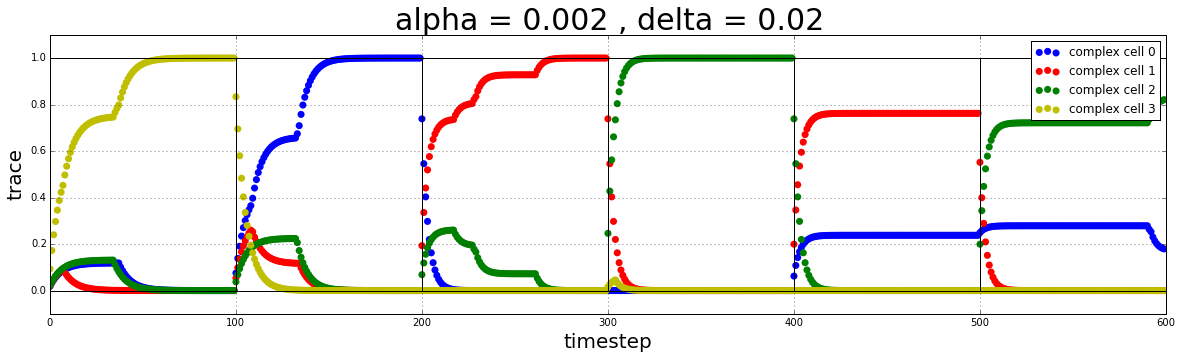

None


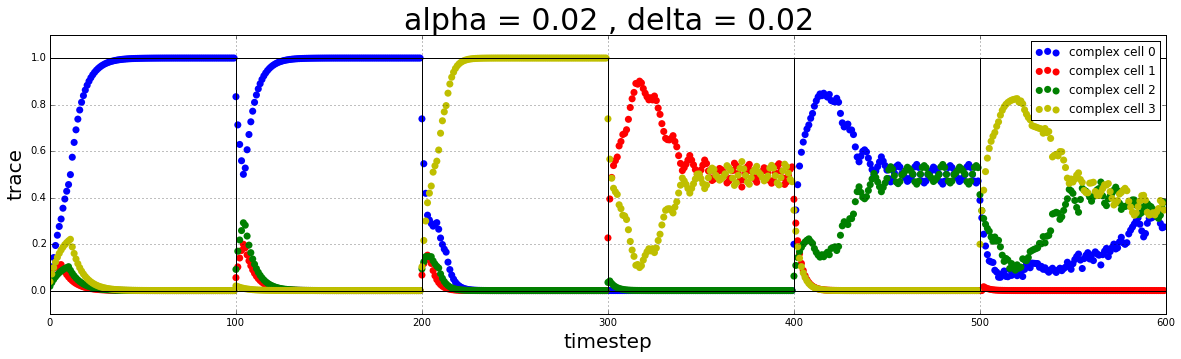

None


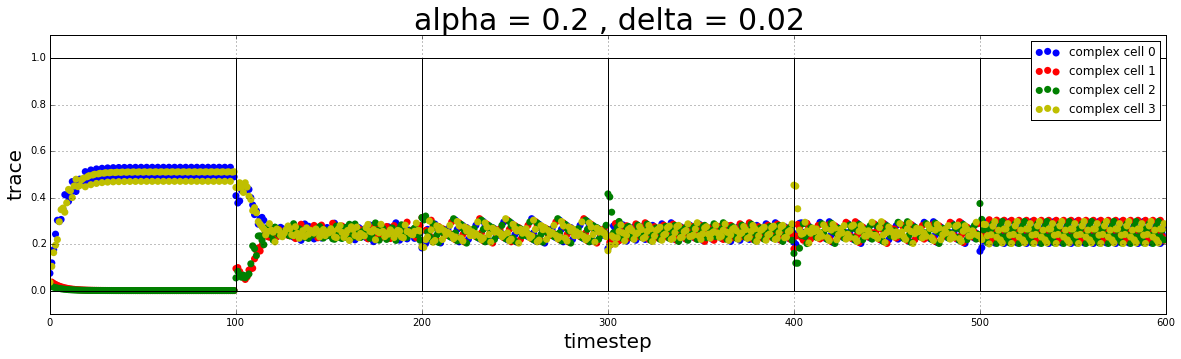

None


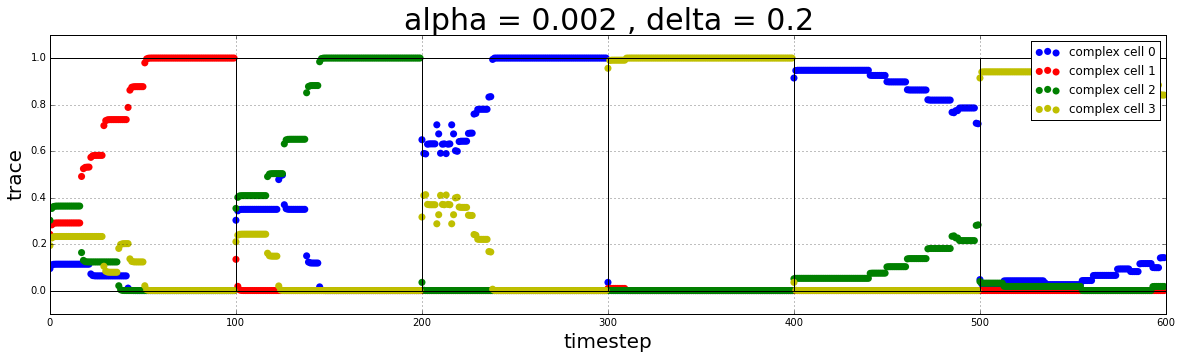

None


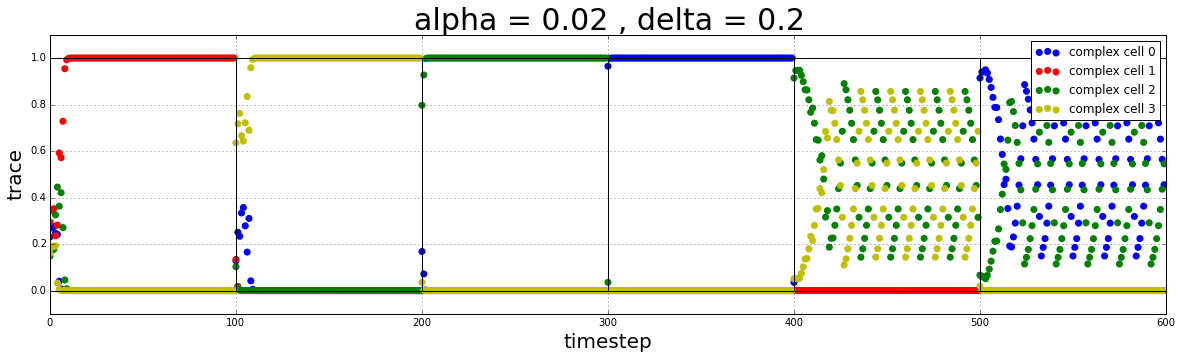

None


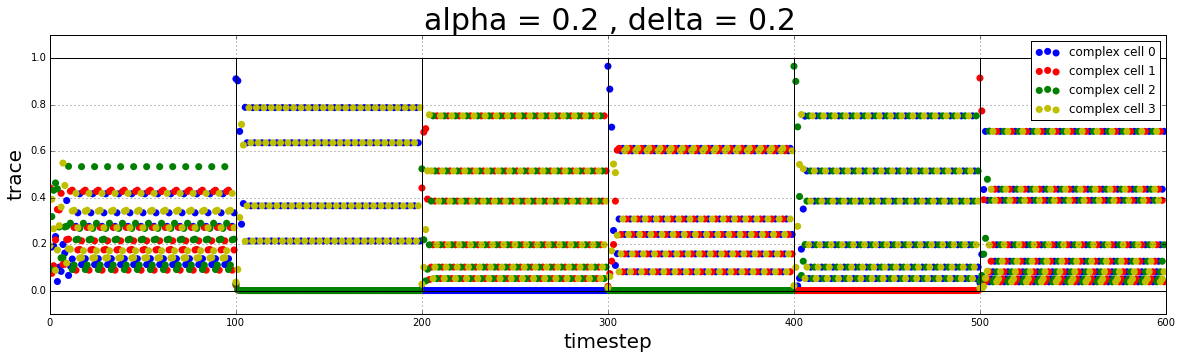

None


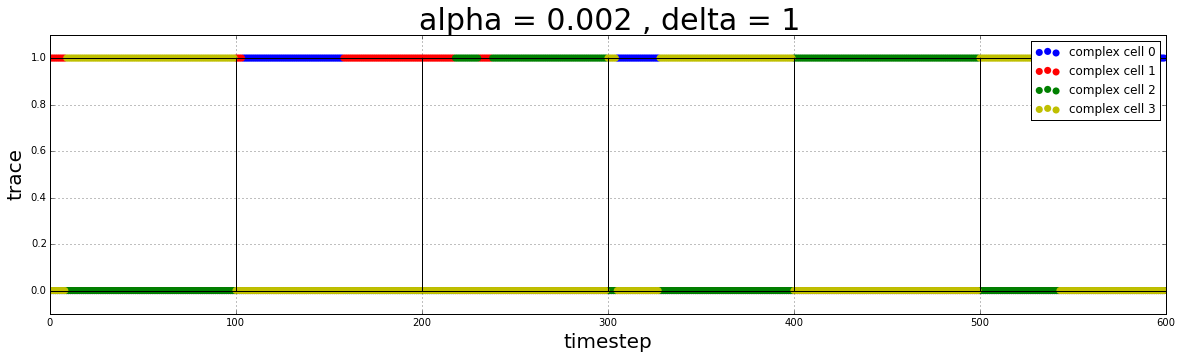

None


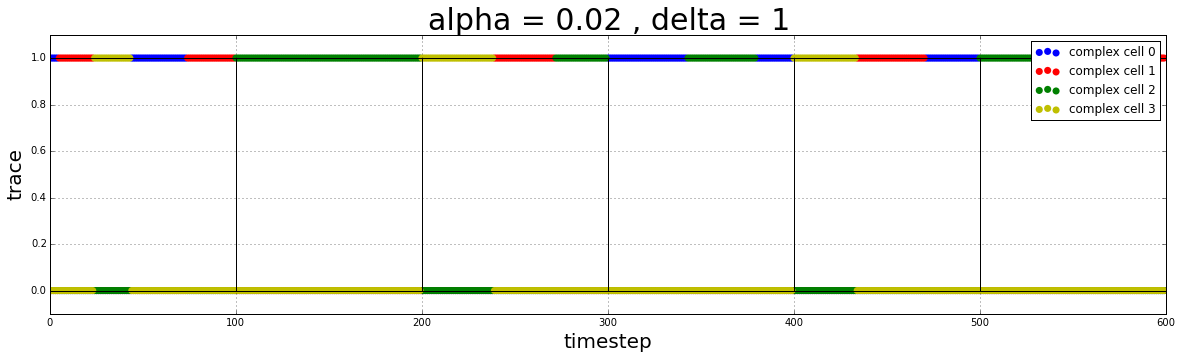

None


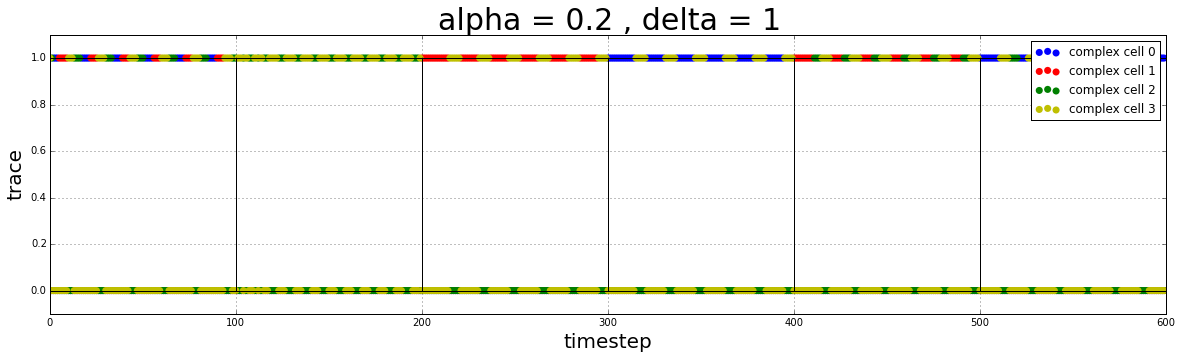

None


In [266]:
for delta in deltas:
    for alpha in alphas:
        print make_figure(get_data(get_records(data, 100, 4, delta, alpha))[0], alpha, delta)